In [16]:
import warnings; warnings.simplefilter('ignore')
import logging, sys
logging.disable(sys.maxsize)
import pandas as pd
import numpy as np
import csv
import pickle
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from multi_freq_ldpy.pure_frequency_oracles.GRR import GRR_Client
from diffprivlib.mechanisms import Geometric
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# Plotting 

## Performance metrics

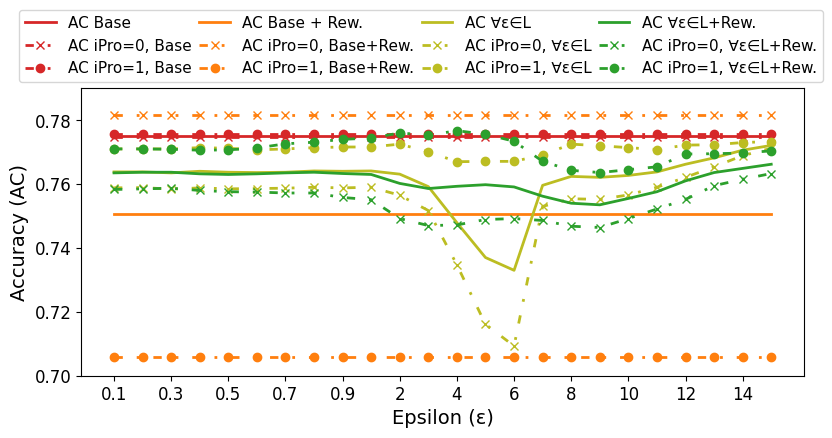

In [84]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] =  11
plt.rcParams['legend.handlelength'] = 2

# figure
fig, ax = plt.subplots(figsize=(8,3.5))
fig.tight_layout(pad=1)


# base model
#--------------
folder_name_base = "RF_Base"
dico_result_base = pickle.load(open(folder_name_base + "/" + "dico_metrics.dat", "rb"))
ax.plot([dico_result_base["acc"]/100 for _ in range(len(eps_values))], color="tab:red", 
        label="AC Base")
ax.plot([dico_result_base["More vol"]["acc"]/100 for _ in range(len(eps_values))], color="tab:red", 
        label="AC iPro=0, Base", linestyle=(0,(3,5,1,5)), marker="x")
ax.plot([dico_result_base["More prof"]["acc"]/100 for _ in range(len(eps_values))], color="tab:red", 
        label="AC iPro=1, Base", linestyle=(0,(3,5,1,5)), marker="o")


# base model + reweight
#----------------------
folder_name_rew = "RF_PreReweight"
dico_result_base = pickle.load(open(folder_name_rew + "/" + "dico_metrics.dat", "rb"))
ax.plot([dico_result_base["acc"]/100 for _ in range(len(eps_values))], color="tab:orange", 
        label="AC Base + Rew.")
ax.plot([dico_result_base["More vol"]["acc"]/100 for _ in range(len(eps_values))], color="tab:orange", 
        label="AC iPro=0, Base+Rew.", linestyle=(0,(3,5,1,5)), marker="x")
ax.plot([dico_result_base["More prof"]["acc"]/100 for _ in range(len(eps_values))], color="tab:orange", 
        label="AC iPro=1, Base+Rew.", linestyle=(0,(3,5,1,5)), marker="o")


# private models with GRR + Geometric
# -----------------------------------
folder_name_dp = "RF_PreGEOGRR_Eps_0.01_15"
dico_result_all = pickle.load(open(folder_name_dp + "/" + "dico_result_all.dat", "rb"))

k = ("acc", "AC ∀ε∈L") 
lst = []
for eps in dico_result_all.keys():
    lst.append(dico_result_all[eps][k[0]]/100)
ax.plot(lst, label=k[1], color="tab:olive")

k = ("acc-more_vol-0", "AC iPro=0, ∀ε∈L")
lst = []
for eps in dico_result_all.keys():
    lst.append(dico_result_all[eps][k[0]]/100)
ax.plot(lst, label=k[1], color="tab:olive", linestyle=(0,(3,5,1,5)), marker="x")

k = ("acc-more_prof-1", "AC iPro=1, ∀ε∈L")
lst = []
for eps in dico_result_all.keys():
    lst.append(dico_result_all[eps][k[0]]/100)
ax.plot(lst, label=k[1], color="tab:olive", linestyle=(0,(3,5,1,5)), marker="o")


# private models with GRR + Geometric + Rew
# -----------------------------------------
folder_name_dp_rew = "RF_PreGEOGRR_PreRew_Eps_0.01_15"
dico_result_all = pickle.load(open(folder_name_dp_rew + "/" + "dico_result_all.dat", "rb"))

k = ("acc", "AC ∀ε∈L+Rew.") 
lst = []
for eps in dico_result_all.keys():
    lst.append(dico_result_all[eps][k[0]]/100)
ax.plot(lst, label=k[1], color="tab:green")

k = ("acc-more_vol-0", "AC iPro=0, ∀ε∈L+Rew.")
lst = []
for eps in dico_result_all.keys():
    lst.append(dico_result_all[eps][k[0]]/100)
ax.plot(lst, label=k[1], color="tab:green", linestyle=(0,(3,5,1,5)), marker="x")

k = ("acc-more_prof-1", "AC iPro=1, ∀ε∈L+Rew.")
lst = []
for eps in dico_result_all.keys():
    lst.append(dico_result_all[eps][k[0]]/100)
ax.plot(lst, label=k[1], color="tab:green", linestyle=(0,(3,5,1,5)), marker="o")


# axes
bbox = (0.47, 1.3)
ax.legend(columnspacing=0.5, ncol=4, loc='upper center', bbox_to_anchor=bbox)
ax.set_xlabel("Epsilon (ε)", fontsize=14)
ax.set_ylabel("Accuracy (AC)", fontsize=14)
ax.set_xticks(range(len(eps_values)))
ax.set_xticks(ax.get_xticks()[::2], eps_values[::2])
ax.set_ylim(0.70, 0.79)


## Fairness metrics

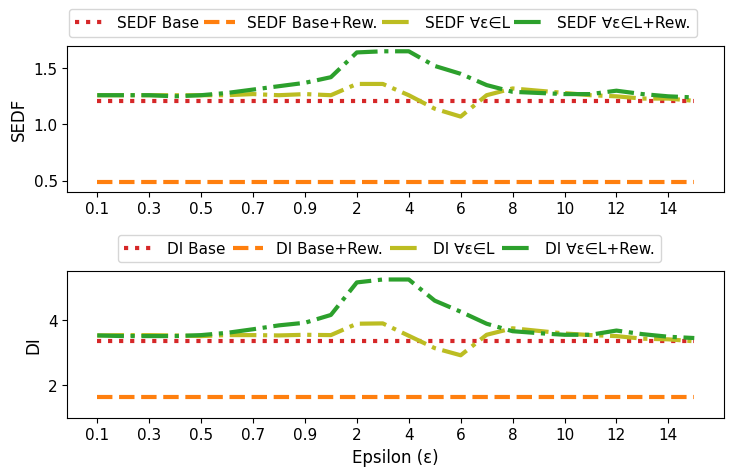

In [90]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] =  11
plt.rcParams['legend.handlelength'] = 2

# figure
fig, ax = plt.subplots(figsize=(8,5), nrows=2)
fig.tight_layout(pad=3.5)

# base model
#--------------
folder_name_base = "RF_Base"
dico_result_base = pickle.load(open(folder_name_base + "/" + "dico_metrics.dat", "rb"))
ax[0].plot([dico_result_base["smoothed"] for _ in range(len(eps_values))], color="tab:red", 
        label="SEDF Base", linestyle="dotted")
ax[1].plot([dico_result_base["disparate"] for _ in range(len(eps_values))], color="tab:red", 
        label="DI Base", linestyle="dotted")

# base model + reweight
#----------------------
folder_name_rew = "RF_PreReweight"
dico_result_base = pickle.load(open(folder_name_rew + "/" + "dico_metrics.dat", "rb"))
ax[0].plot([dico_result_base["smoothed"] for _ in range(len(eps_values))], color="tab:orange", 
        label="SEDF Base+Rew.", linestyle="dashed")
ax[1].plot([dico_result_base["disparate"] for _ in range(len(eps_values))], color="tab:orange", 
        label="DI Base+Rew.", linestyle="dashed")

# private models with GRR + Geometric
# -----------------------------------
folder_name_dp = "RF_PreGEOGRR_Eps_0.01_15"
dico_result_all = pickle.load(open(folder_name_dp + "/" + "dico_result_all.dat", "rb"))
k = ("smoothed", "SEDF ∀ε∈L") 
lst = []
for eps in dico_result_all.keys():
    lst.append(dico_result_all[eps][k[0]])
ax[0].plot(lst, label=k[1], color="tab:olive", linestyle="dashdot")

k = ("disparate", "DI ∀ε∈L") 
lst = []
for eps in dico_result_all.keys():
    lst.append(dico_result_all[eps][k[0]])
ax[1].plot(lst, label=k[1], color="tab:olive", linestyle="dashdot")

# private models with GRR + Geometric + Rew
# -----------------------------------------
folder_name_dp_rew = "RF_PreGEOGRR_PreRew_Eps_0.01_15"
dico_result_all = pickle.load(open(folder_name_dp_rew + "/" + "dico_result_all.dat", "rb"))
k = ("smoothed", "SEDF ∀ε∈L+Rew.") 
lst = []
for eps in dico_result_all.keys():
    lst.append(dico_result_all[eps][k[0]])
ax[0].plot(lst, label=k[1], color="tab:green", linestyle="dashdot")

k = ("disparate", "DI ∀ε∈L+Rew.") 
lst = []
for eps in dico_result_all.keys():
    lst.append(dico_result_all[eps][k[0]])
ax[1].plot(lst, label=k[1], color="tab:green", linestyle="dashdot")

# axes
bbox = (0.48, 1.3)
ax[0].legend(columnspacing=0.3, ncol=4, loc='upper center', bbox_to_anchor=bbox)
ax[0].set_ylabel("SEDF")
ax[0].set_xticks(range(len(eps_values)))
ax[0].set_xticks(ax[0].get_xticks()[::2], eps_values[::2])

bbox = (0.49, 1.3)
ax[1].legend(columnspacing=0.5, ncol=4, loc='upper center', bbox_to_anchor=bbox)
ax[1].set_ylabel("DI")
ax[1].set_xticks(range(len(eps_values)))
ax[1].set_xticks(ax[1].get_xticks()[::2], eps_values[::2])
ax[1].set_xlabel("Epsilon (ε)")

ax[0].set_ylim(0.4,1.7)
ax[1].set_ylim(1,5.5)


## Feature importance

In [65]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] =  11
plt.rcParams['legend.handlelength'] = 2

# base model
# --------------
folder_name_base = "RF_Base"
best_iter = "43"
base = pickle.load(open(folder_name_base + "/" + "ITER_"+str(best_iter)+".dat", "rb"))
base.update(pickle.load(open(folder_name_base + "/" + "train_test_xy.dat", "rb")))

# params
#---------------
params = {'n_estimators': 200, 'max_depth': 14, 'max_features': 0.8, 'max_samples': 0.95, 'class_weight': {0: 1, 1: 2}}

# base model + reweight
# ---------------------
folder_name_rew = "RF_PreReweight"
rew = {}
rew.update(pickle.load(open(folder_name_rew + "/" + "train_test_xy.dat", "rb"))) 
rew["ds_transf_train"] = pickle.load(open(folder_name_rew + "/" + "ds_transf_train.dat", "rb"))

rew_model = RandomForestClassifier(random_state=SEED,
                               n_jobs=-1)
rew_model.set_params(**params)
rew_model.fit(rew["X_train"], rew["y_train"],
          sample_weight=rew["ds_transf_train"].instance_weights)


# extracting importances
# ----------------------
# base
base_impor = base["model"].feature_importances_
base_forest = pd.Series(base_impor, index=base["X_train"].columns)
base_forest = base_forest.to_dict()

# base + rew
rew_impor = rew_model.feature_importances_
rew_forest = pd.Series(rew_impor, index=rew["X_train"].columns)
rew_forest = rew_forest.to_dict()

# private models 
folder_name_dp = "RF_PreGEOGRR_Eps_0.01_15"
dico_result_all = pickle.load(open(folder_name_dp + "/" + "dico_result_all.dat", "rb"))
epsval = 9
eps15_forest = {k.split("feat_")[1]:dico_result_all[epsval][k] 
                    for k in dico_result_all[epsval].keys() if "feat_" in k}
epsval = 3
eps3_forest = {k.split("feat_")[1]:dico_result_all[epsval][k] 
                    for k in dico_result_all[epsval].keys() if "feat_" in k}
epsval = 0.5
eps05_forest = {k.split("feat_")[1]:dico_result_all[epsval][k] 
                    for k in dico_result_all[epsval].keys() if "feat_" in k}

# private models + rew
folder_name_dp_rew = "RF_PreGEOGRR_PreRew_Eps_0.01_15"
dico_result_all = pickle.load(open(folder_name_dp_rew + "/" + "dico_result_all.dat", "rb"))
epsval = 9
eps15_rew_forest = {k.split("feat_")[1]:dico_result_all[epsval][k] 
                    for k in dico_result_all[epsval].keys() if "feat_" in k}
epsval = 6
eps3_rew_forest = {k.split("feat_")[1]:dico_result_all[epsval][k] 
                    for k in dico_result_all[epsval].keys() if "feat_" in k}
epsval = 0.5
eps05_rew_forest = {k.split("feat_")[1]:dico_result_all[epsval][k] 
                    for k in dico_result_all[epsval].keys() if "feat_" in k}

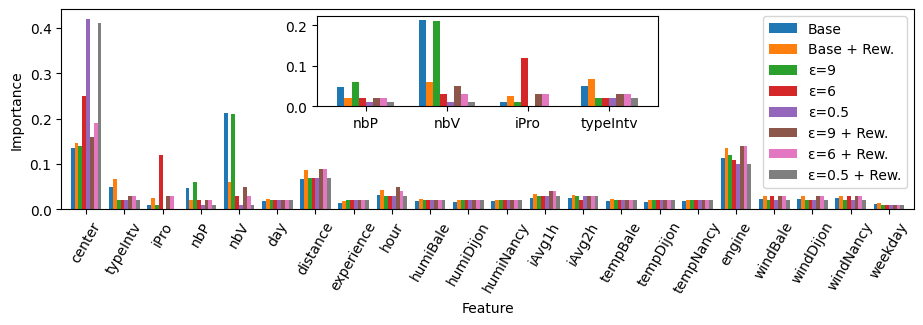

In [66]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes

import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 10
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
#plt.rcParams['font.weight'] = 'bold'
plt.rcParams['legend.title_fontsize'] = 11
plt.rcParams['legend.fontsize'] =  10
plt.rcParams['legend.handlelength'] = 2

# plot
fig, ax = plt.subplots(figsize=(11,2.6))
dico = {"center":"center",
        "motif":"typeIntv",
        "ind_prof":"iPro",
        "nb_spp":"nbP",
        "nb_spv":"nbV",
        'bisonFuteDepart':"traficDepart", 
        'bisonFuteRetour':"traficReturn", 
        'day':"day", 
        'distance':"distance", 
        'experience':"experience", 
        'hour':"hour", 
        'humidite_Bale':"humiBale", 
        'humidite_Dijon':"humiDijon", 
        'humidite_Nancy':"humiNancy", 
        'ind_avg1':"iAvg1h", 
        'ind_avg2':"iAvg2h", 
        'ind_avg3':"iAvg3h",  
        'jour':"isNight", 
        'month':"month", 
        'nebulosite_Bale':"cloudinessBale", 
        'precipitations1h_Bale':"precipBale", 
        'precipitations1h_Dijon':"precipDijon", 
        'precipitations1h_Nancy':"precipNancy",
        'temperature_Bale':"tempBale", 
        'temperature_Dijon':"tempDijon", 
        'temperature_Nancy':"tempNancy", 
        'type':"engine", 
        'vitesseVent_Bale':"windBale", 
        'vitesseVent_Dijon':"windDijon", 
        'vitesseVent_Nancy':"windNancy", 
        'weekday':"weekday", 
        'year':"year"
       }
#lst = sorted(list(base_forest.keys()))
lst = ["center",
        "motif",
        "ind_prof",
        "nb_spp",
        "nb_spv",
        'day', 
        'distance', 
        'experience', 
        'hour', 
        'humidite_Bale', 
        'humidite_Dijon', 
        'humidite_Nancy', 
        'ind_avg1', 
        'ind_avg2', 
        'temperature_Bale', 
        'temperature_Dijon', 
        'temperature_Nancy', 
        'type', 
        'vitesseVent_Bale', 
        'vitesseVent_Dijon', 
        'vitesseVent_Nancy', 
        'weekday', 
      ]
df = pd.DataFrame()
df["Feature"] = [dico[f] for f in lst]
df["Base"] = [base_forest[f] for f in lst]
df["Base + Rew."] = [rew_forest[f] for f in lst]
df["ε=9"] = [eps9_forest[f] for f in lst]
df["ε=6"] = [eps6_forest[f] for f in lst]
df["ε=0.5"] = [eps05_forest[f] for f in lst]
df["ε=9 + Rew."] = [eps9_rew_forest[f] for f in lst]
df["ε=6 + Rew."] = [eps6_rew_forest[f] for f in lst]
df["ε=0.5 + Rew."] = [eps05_rew_forest[f] for f in lst]
df.set_index("Feature", inplace=True)
df.plot.bar(rot=60, ax=ax, width=0.8) 
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")

# zoom
ax1 = inset_axes(ax, width="40%", height="45%", loc=9)
ax1.xaxis.set_visible(True)
ax1.yaxis.set_visible(True)

lst = ["nb_spp", "nb_spv", "ind_prof", "motif"]
df = pd.DataFrame()
df["Feature"] = [dico[f] for f in lst]
df["Base"] = [base_forest[f] for f in lst]
df["Base + Rew."] = [rew_forest[f] for f in lst]
df["ε=9"] = [eps9_forest[f] for f in lst]
df["ε=6"] = [eps6_forest[f] for f in lst]
df["ε=0.5"] = [eps05_forest[f] for f in lst]
df["ε=9 + Rew."] = [eps9_rew_forest[f] for f in lst]
df["ε=6 + Rew."] = [eps6_rew_forest[f] for f in lst]
df["ε=0.5 + Rew."] = [eps05_rew_forest[f] for f in lst]
df.set_index("Feature", inplace=True)
df.plot.bar(rot=0, ax=ax1, legend=None, width=0.7) 
ax1.set_xlabel("")
ax.legend(loc=1)